<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/TimeSeries_Wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.engine import Input
from keras.engine import Model

from keras.layers import Conv1D
from keras.utils.conv_utils import conv_output_length
from keras import layers
from keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


# Classe CaudalDilatedConv1D

In [8]:
class CausalDilatedConv1D(Conv1D):
    def __init__(self, nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None,
                 border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None,
                 activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True, causal=False, **kwargs):
        super(CausalDilatedConv1D, self).__init__(nb_filter, filter_length, weights=weights, activation=activation, 
                padding=border_mode, strides=subsample_length, dilation_rate=atrous_rate, kernel_regularizer=W_regularizer, 
                bias_regularizer=b_regularizer, activity_regularizer=activity_regularizer, kernel_constraint=W_constraint, 
                bias_constraint=b_constraint, use_bias=bias, **kwargs)
        self.causal = causal
        self.nb_filter = nb_filter
        self.atrous_rate = atrous_rate
        self.filter_length = filter_length
        self.subsample_length = subsample_length
        self.border_mode = border_mode
        if self.causal and border_mode != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]
        if self.causal:
            input_length += self.atrous_rate * (self.filter_length - 1)
        length = conv_output_length(input_length, self.filter_length, self.border_mode, self.strides[0], dilation=self.atrous_rate)
        return (input_shape[0], length, self.nb_filter)

    def call(self, x, mask=None):
        if self.causal:
            x = K.temporal_padding(x, padding=(self.atrous_rate * (self.filter_length - 1), 0))
        # return super(CausalAtrousConvolution1D, self).call(x, mask)
        return super(CausalDilatedConv1D, self).call(x)

# Wavenet Model

**1. Méthodes**

In [9]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

**2. Modèle**

In [10]:
def build_model_residual_block(x, i, s,filters, use_bias,res_l2):
        original_x = x
        # TODO: initalization, regularization?
        tanh_out = CausalDilatedConv1D(filters, 2, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=use_bias, name='dilated_conv_%d_tanh_s%d' % (2 ** i, s), activation='tanh', W_regularizer=l2(res_l2))(x)
        sigm_out = CausalDilatedConv1D(filters, 2, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=use_bias, name='dilated_conv_%d_sigm_s%d' % (2 ** i, s), activation='sigmoid', W_regularizer=l2(res_l2))(x)
        x = layers.Multiply()([tanh_out, sigm_out])

        res_x = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(x)
        skip_x = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(x)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model(fragment_length, filters, output_bins, dilation_depth, stacks, use_skip_connections,learn_all_outputs, use_bias, res_l2, final_l2):
        input_shape = Input(shape=(fragment_length, output_bins), name='input_part')
        out = input_shape
        skip_connections = []
        out = CausalDilatedConv1D(filters, 2, atrous_rate=1, border_mode='valid', causal=True, name='initial_causal_conv')(out)
        for s in range(stacks):
            for i in range(0, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, filters, use_bias, res_l2)
                skip_connections.append(skip_out)

        if use_skip_connections:
            out = layers.Add()(skip_connections)
        out = layers.Activation('relu')(out)
        out = layers.Conv1D(output_bins, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        out = layers.Activation('relu')(out)
        out = layers.Conv1D(output_bins, 1, padding='same')(out)
        if not learn_all_outputs:
            raise DeprecationWarning('Learning on just all outputs is wasteful, now learning only inside receptive field.')
            out = layers.Lambda(lambda x: x[:, -1, :], output_shape=(out._keras_shape[-1],))(out)  # Based on gif in deepmind blog: take last output?

        out = layers.Activation('softmax', name="output_softmax")(out)
        model = Model(input_shape, out)
        receptive_field = _compute_receptive_field(dilation_depth, stacks)
        return model


# TimeSeries Wavenet Model

**1. Méthodes**

In [14]:
def _compute_receptive_field(dilation_depth, stacks):
  return stacks * (2 ** dilation_depth * 2) - (stacks - 1)

**2. Modèle**

In [26]:
def build_model_residual_block(x, i, s,filters, use_bias,res_l2):
        original_x = x
        # TODO: initalization, regularization?
        relu_out = CausalDilatedConv1D(filters, 2, atrous_rate=2 ** i, border_mode='valid', causal=True, bias=True, name='dilated_conv_%d_relu_s%d' % (2 ** i, s), activation='relu', W_regularizer=l2(res_l2))(x)
        res_x = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        skip_x = layers.Conv1D(filters, 1, padding='same', use_bias=use_bias, kernel_regularizer=l2(res_l2))(relu_out)
        res_x = layers.Add()([original_x, res_x])
        return res_x, skip_x

def build_model(fragment_length, filters, output_bins, dilation_depth, stacks, use_skip_connections, use_bias, res_l2, final_l2):
        input_shape = Input(shape=(fragment_length, output_bins), name='input_part')
        out = input_shape
        skip_connections = []

        for s in range(stacks):
            for i in range(0, dilation_depth + 1):
                out, skip_out = build_model_residual_block(out, i, s, filters, use_bias, res_l2)
                skip_connections.append(skip_out)

        if use_skip_connections:
            out = layers.Add()(skip_connections)

        out = layers.Activation('linear', name="output_linear")(out)
        out = layers.Conv1D(output_bins, 1, padding='same', kernel_regularizer=l2(final_l2))(out)
        model = Model(input_shape, out)
        return model


In [139]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 2
nb_output_bins = 1
dilation_depth = 3
nb_stacks = 1
use_skip_connections = True
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, nb_output_bins, dilation_depth, nb_stacks, use_skip_connections, use_bias, res_l2, final_l2)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
dilated_conv_1_relu_s0 (CausalD (None, 16, 2)        6           input_part[0][0]                 
__________________________________________________________________________________________________
conv1d_147 (Conv1D)             (None, 16, 2)        4           dilated_conv_1_relu_s0[0][0]     
__________________________________________________________________________________________________
add_76 (Add)                    (None, 16, 2)        0           input_part[0][0]                 
                                                                 conv1d_147[0][0]          

In [138]:
x = tf.reshape(np.linspace(1,16000,16000),shape=(1000,16,1))
print(x.shape)

y = CausalDilatedConv1D(2, 2, atrous_rate=2 ** 0, border_mode='valid', causal=True, bias=True, activation='relu',)(x)
y = CausalDilatedConv1D(2, 2, atrous_rate=2 ** 1, border_mode='valid', causal=True, bias=True, activation='relu',)(y)
y = CausalDilatedConv1D(2, 2, atrous_rate=2 ** 2, border_mode='valid', causal=True, bias=True, activation='relu',)(y)

y = layers.Activation('linear', name="output_linear")(y)

y = layers.Conv1D(1, 1, padding='same')(y)


#y = CausalDilatedConv1D(2, 2, atrous_rate=1, border_mode='valid', causal=True, bias=True, activation='relu')(x)

print(y.shape)

(1000, 16, 1)
(1000, 16, 1)


# Définition de la série

(1000,)


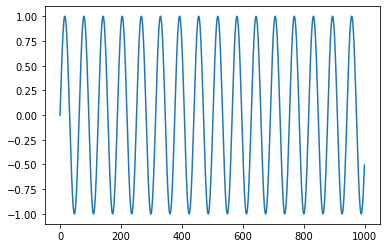

In [205]:
t = np.linspace(0,100,100*10)
print(t.shape)
sin = np.sin(t)
plt.plot(sin)

In [206]:
sin = np.insert(sin,0,np.zeros(16))
sin[0:50]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.09993302,  0.19886554,  0.29580708,
        0.3897871 ,  0.47986471,  0.56513807,  0.64475345,  0.71791378,
        0.7838866 ,  0.84201141,  0.89170627,  0.93247368,  0.96390547,
        0.98568695,  0.99760007,  0.99952556,  0.99144412,  0.97343668,
        0.94568351,  0.90846248,  0.86214622,  0.80719845,  0.74416927,
        0.67368972,  0.59646541,  0.51326949,  0.42493488,  0.33234597,
        0.23642973,  0.13814643,  0.03848005, -0.06157158, -0.16100677])

In [207]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(sin) * pourcentage)

serie_entrainement = sin[:temps_separation]
serie_test = sin[temps_separation:]

print("Taille de l'entrainement : %d" %len(serie_entrainement))
print("Taille de la validation : %d" %len(serie_test))

Taille de l'entrainement : 812
Taille de la validation : 204


No handles with labels found to put in legend.


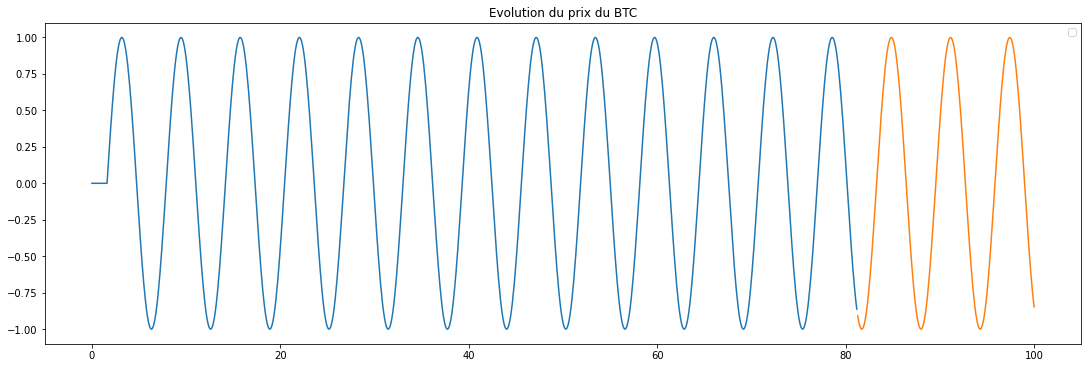

In [217]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
ax.plot(t[0:temps_separation],serie_entrainement)
ax.plot(t[temps_separation:],serie_test[:-16])

ax.set_title("Evolution du prix du BTC")

ax.legend()
plt.show()

In [218]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(serie_entrainement))
std = tf.math.reduce_std(np.asarray((serie_entrainement)))

# Normalisation des données
serie_entrainement = (serie_entrainement-mean)/std
serie_test = (serie_test-mean)/std

In [225]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(serie, taille_fenetre, horizon, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (tf.expand_dims(x[0:taille_fenetre],axis=1),x[-taille_fenetre:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [226]:
toto = np.linspace(0,1000,1001)
toto = np.insert(toto,0,np.zeros(16))

In [227]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 16
horizon = 1
batch_size = 1

dataset = prepare_dataset_XY(toto,taille_fenetre,horizon,batch_size)

In [ ]:
for element in dataset.take(3):
  print(element)

In [231]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 16
horizon = 1
batch_size = 1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,horizon,batch_size)

In [232]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

796
(1, 16, 1)
(1, 16)


In [233]:
for element in dataset.take(1):
  print(element)


(<tf.Tensor: shape=(1, 16, 1), dtype=float64, numpy=
array([[[-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507],
        [-0.02577507]]])>, <tf.Tensor: shape=(1, 16), dtype=float64, numpy=
array([[-0.02577507, -0.02577507, -0.02577507, -0.02577507, -0.02577507,
        -0.02577507, -0.02577507, -0.02577507, -0.02577507, -0.02577507,
        -0.02577507, -0.02577507, -0.02577507, -0.02577507, -0.02577507,
        -0.02577507]])>)


In [235]:
# Extrait les X,Y du dataset
#56x((1000,4,1),(1000,1)) => (56*1000,4,1) ; (56*1000,1)

x,y = tuple(zip(*dataset))

# Recombine les données
# (56,1000,4,1) => (56*128,4,1)
# (56,1000,1) => (56*128,1)
x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1],taille_fenetre)))

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(796, 16, 1)
(796, 16)


In [236]:
# Extrait les X,Y du dataset_val

x,y = tuple(zip(*dataset_val))

# Recombine les données

x_val = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_val = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1],taille_fenetre)))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(188, 16, 1)
(188, 16)


In [237]:
# Création des instants d'entrainement et de validation
y_train_timing = t[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = t[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Utilisation du model

In [238]:
def compute_receptive_field_(dilation_depth, nb_stacks):
    receptive_field = nb_stacks * (2 ** dilation_depth * 2) - (nb_stacks - 1)
    return receptive_field

nb_filters = 2
nb_output_bins = 1
dilation_depth = 3
nb_stacks = 1
use_skip_connections = True
use_bias = False
res_l2 = 0
final_l2 = 0

fragment_length = compute_receptive_field_(dilation_depth, nb_stacks)
fragment_length

model = build_model(fragment_length, nb_filters, nb_output_bins, dilation_depth, nb_stacks, use_skip_connections, use_bias, res_l2, final_l2)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
dilated_conv_1_relu_s0 (CausalD (None, 16, 2)        6           input_part[0][0]                 
__________________________________________________________________________________________________
conv1d_174 (Conv1D)             (None, 16, 2)        4           dilated_conv_1_relu_s0[0][0]     
__________________________________________________________________________________________________
add_91 (Add)                    (None, 16, 2)        0           input_part[0][0]                 
                                                                 conv1d_174[0][0]          

In [239]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

Epoch 1/100
796/796 [==============================] - 3s 2ms/step - loss: 1.4099 - mse: 1.4099

Epoch 00001: loss improved from inf to 1.47007, saving model to poids.hdf5
Epoch 2/100
796/796 [==============================] - 2s 2ms/step - loss: 1.4099 - mse: 1.4099

Epoch 00002: loss improved from 1.47007 to 1.47004, saving model to poids.hdf5
Epoch 3/100
796/796 [==============================] - 2s 2ms/step - loss: 1.4098 - mse: 1.4098

Epoch 00003: loss improved from 1.47004 to 1.46998, saving model to poids.hdf5
Epoch 4/100
796/796 [==============================] - 2s 2ms/step - loss: 1.4098 - mse: 1.4098

Epoch 00004: loss improved from 1.46998 to 1.46990, saving model to poids.hdf5
Epoch 5/100
796/796 [==============================] - 2s 2ms/step - loss: 1.4097 - mse: 1.4097

Epoch 00005: loss improved from 1.46990 to 1.46978, saving model to poids.hdf5
Epoch 6/100
796/796 [==============================] - 2s 2ms/step - loss: 1.4095 - mse: 1.4095

Epoch 00006: loss improved 

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

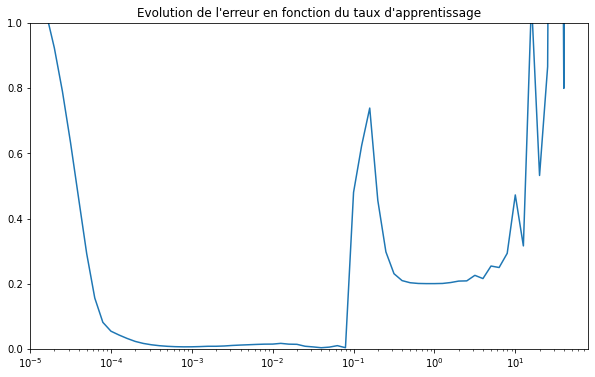

In [242]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [243]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [244]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

 
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.005,periodes = 10, term="loss")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=0.1,periodes = 10, term="val_My_MSE")])


Epoch 1/1000
796/796 [==============================] - 3s 3ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0056 - val_mse: 0.0056

Epoch 00001: loss improved from inf to 0.00931, saving model to poids_train.hdf5
Epoch 2/1000
796/796 [==============================] - 2s 2ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0052 - val_mse: 0.0052

Epoch 00002: loss improved from 0.00931 to 0.00648, saving model to poids_train.hdf5
Epoch 3/1000
796/796 [==============================] - 2s 2ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0051 - val_mse: 0.0051

Epoch 00003: loss improved from 0.00648 to 0.00598, saving model to poids_train.hdf5
Epoch 4/1000
796/796 [==============================] - 2s 2ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0050 - val_mse: 0.0050

Epoch 00004: loss improved from 0.00598 to 0.00573, saving model to poids_train.hdf5
Epoch 5/1000
796/796 [==============================] - 2s 2ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0050 - val_ms

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

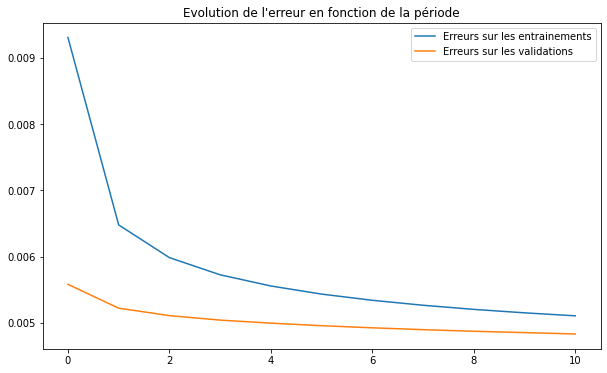

In [245]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [246]:
# Evaluation du modèle
# Avec le modèle type encodeur/décodeur :
# 56/56 [==============================] - 7s 113ms/step - loss: 1.1795e-04 - mse: 2.3664e-04 - My_MSE: 2712.2415
# 14/14 [==============================] - 2s 113ms/step - loss: 0.3602 - mse: 1.9360 - My_MSE: 9650.2637
model.evaluate(dataset)
model.evaluate(dataset_val)


188/188 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 0.0048


[0.004832226317375898, 0.004832226317375898]

In [301]:
# Calcul des prédictions
pred_ent = model.predict(x_train, verbose=1)
pred_val = model.predict(x_val, verbose=1)

6/6 [==============================] - 0s 3ms/step


In [ ]:
pred_ent[:,15,0]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=t[0:temps_separation],y=serie_entrainement,line=dict(color='blue', width=1),name="Prix BTC"))
fig.add_trace(go.Scatter(x=t[taille_fenetre+horizon-1:temps_separation],y=pred_ent[:,15,0],line=dict(color='green', width=1),name="predictions"))

fig.add_trace(go.Scatter(x=t[temps_separation:],y=pred_val[:,15,0],line=dict(color='green', width=1),name="predictions"))



In [295]:
predictions = []

time = np.linspace(0,len(x_train),len(x_train)+1)

for t in range(0,600):
  data_to_predict = tf.expand_dims(x_train[t],0)
  predictions.append(model.predict(data_to_predict)[0,15,0])

In [299]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
fig.add_trace(go.Scatter(x=time,y=serie_entrainement,line=dict(color='blue', width=1),name="Prix BTC"))
fig.add_trace(go.Scatter(x=time[taille_fenetre:],y=predictions,line=dict(color='green', width=1),name="predictions"))
